<a href="https://colab.research.google.com/github/zinseo964/dam_flow/blob/main/hr_dam_lstm(includesthepreviousdam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" LSTM prediction: stacked LSTM """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
data = pd.read_csv('/content/drive/MyDrive/240410/data_hr - data_hr.csv', encoding='utf-8')

In [109]:
print(data)

                    date      dam   90  100  101  211  212
0        2000-01-01 0:00   13.100  0.1  0.0  0.0  0.0  0.0
1        2000-01-01 1:00    0.000  0.0  0.0  0.0  0.0  0.0
2        2000-01-01 2:00    0.000  0.0  0.0  0.0  0.0  0.0
3        2000-01-01 3:00  143.400  0.7  0.0  0.0  0.0  0.0
4        2000-01-01 4:00    0.000  0.0  0.0  0.0  0.0  0.0
...                  ...      ...  ...  ...  ...  ...  ...
210379  2023-12-31 19:00  173.106  0.0  0.0  0.0  0.0  0.0
210380  2023-12-31 20:00    0.000  0.0  0.0  0.0  0.0  0.0
210381  2023-12-31 21:00  124.118  0.0  0.0  0.0  0.0  0.0
210382  2023-12-31 22:00   15.417  0.0  0.0  0.0  0.0  0.0
210383  2023-12-31 23:00    0.000  0.0  0.0  0.0  0.0  0.0

[210384 rows x 7 columns]


In [108]:
data = data.fillna(0)
data = data[26280:]
data = data.reset_index(drop=True, inplace=False)

In [110]:
original_dam = data['dam']

In [111]:
print(original_dam)

0          13.100
1           0.000
2           0.000
3         143.400
4           0.000
           ...   
210379    173.106
210380      0.000
210381    124.118
210382     15.417
210383      0.000
Name: dam, Length: 210384, dtype: float64


In [112]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [113]:
# variables for training
cols = list(data)[1:7]

In [114]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [115]:
data.dtypes

date     object
dam     float64
90      float64
100     float64
101     float64
211     float64
212     float64
dtype: object

In [116]:
# new dataframe with only training data - 6 columns
data = data[cols].astype(float)

In [117]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)

In [118]:
dam = data.drop(['90','100','101','211','212'], axis = 1)

In [119]:
scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [120]:
print(dam_data_scaled)

[[0.00123644 0.0011274  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 ...
 [0.01171487 0.         0.         0.         0.         0.        ]
 [0.00145513 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


In [121]:
print(dam_scaled)

[[0.00123644]
 [0.        ]
 [0.        ]
 ...
 [0.01171487]
 [0.00145513]
 [0.        ]]


In [122]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates)

189345   2021-08-07 09:00:00
189346   2021-08-07 10:00:00
189347   2021-08-07 11:00:00
189348   2021-08-07 12:00:00
189349   2021-08-07 13:00:00
                 ...        
210379   2023-12-31 19:00:00
210380   2023-12-31 20:00:00
210381   2023-12-31 21:00:00
210382   2023-12-31 22:00:00
210383   2023-12-31 23:00:00
Name: date, Length: 21039, dtype: datetime64[ns]


In [123]:
print(train_data_scaled)

[[1.23644255e-03 1.12739572e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.71924637e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [124]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 24   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days , 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [125]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(189321, 24, 6) (189321, 1)
(21015, 24, 6) (21015, 1)


In [126]:
print(trainX[:2], trainY[0])

[[[0.00123644 0.0011274  0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.0135348  0.00789177 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.00631435 0.         0.00148588 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.0076263  0.         0.         0.         0.         0.        ]
  [0.         0.         0.00148588 0.         0.         0.        ]
  [0.0013969  0.         0.         0.         0.         0.        ]
  [0.00756023 0.         0.         0.         0.         0.        ]
  [0.         0.         0.00594354 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.    

In [127]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            18176     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [129]:
# Try to load weights
try:
    model.load_weights('/content/drive/MyDrive/240410/hr_dam_lstm_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('/content/drive/MyDrive/240410/hr_dam_lstm_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

Loaded model weights from disk


657/657 [==============================] - 7s 8ms/step
(21015, 1) (21015, 1)
(21015,)


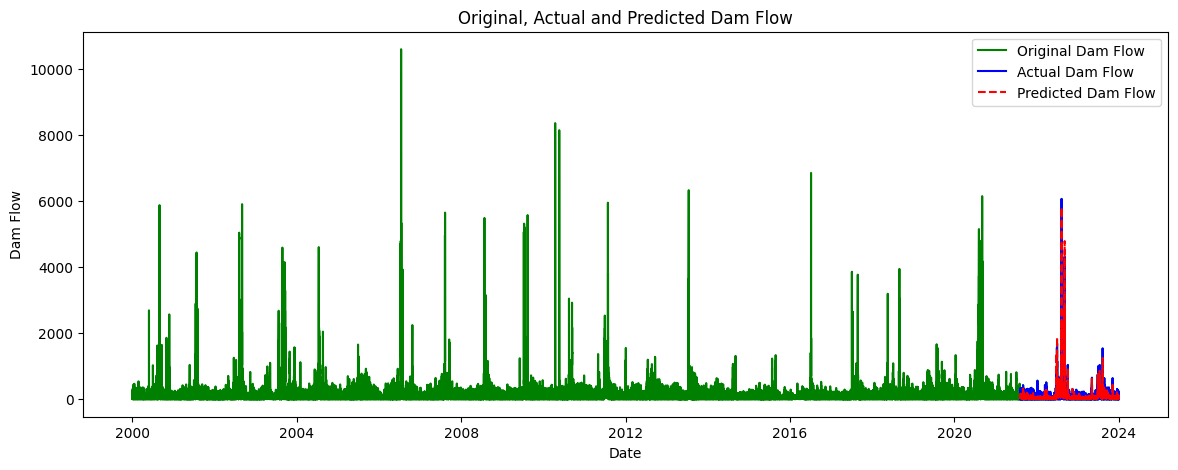

In [130]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
# mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# # substitute predictions into the first column
# mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler_dam.inverse_transform(prediction)[:,0]

# # generate array filled with means for testY
# mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# # substitute testY into the first column
# mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler_dam.inverse_transform(testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [131]:
test_dates

189345   2021-08-07 09:00:00
189346   2021-08-07 10:00:00
189347   2021-08-07 11:00:00
189348   2021-08-07 12:00:00
189349   2021-08-07 13:00:00
                 ...        
210379   2023-12-31 19:00:00
210380   2023-12-31 20:00:00
210381   2023-12-31 21:00:00
210382   2023-12-31 22:00:00
210383   2023-12-31 23:00:00
Name: date, Length: 21039, dtype: datetime64[ns]

In [133]:
# testDates = []
# for day in test_dates[14:]:
#   testDates.append(day.strftime("%Y-%m-%d"))

testDates = pd.DataFrame(test_dates)
pred_y = pd.DataFrame(y_pred)
origin_y = pd.DataFrame(testY_original)

print(len(testDates), len(pred_y), len(origin_y))

lstm_include_dam = pd.concat([testDates, origin_y, pred_y], axis = 1)
print(lstm_include_dam)

lstm_include_dam = pd.DataFrame(lstm_include_dam)
lstm_include_dam.to_csv("/content/drive/MyDrive/240410/compare_dam/hr_lstm_include_dam.csv")

21039 21015 21015
                      date        0          0
189345 2021-08-07 09:00:00      NaN        NaN
189346 2021-08-07 10:00:00      NaN        NaN
189347 2021-08-07 11:00:00      NaN        NaN
189348 2021-08-07 12:00:00      NaN        NaN
189349 2021-08-07 13:00:00      NaN        NaN
...                    ...      ...        ...
21010                  NaT  173.106  68.884674
21011                  NaT    0.000  30.217560
21012                  NaT  124.118  94.746101
21013                  NaT   15.417  51.198082
21014                  NaT    0.000  67.672180

[42054 rows x 3 columns]


In [84]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

print(testX_last)

lstm_include_x = pd.concat([testDates, testX_last,origin_y,pred_y], axis = 1)
lstm_include_x.to_csv("/content/drive/MyDrive/240410/compare_dam/hr_lstm_include_x.csv")

[4.71924637e-05 4.50958286e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
             0    1    2    3    4    5
0        0.500  4.0  0.0  0.0  0.0  0.0
1        0.500  0.2  0.0  0.0  0.0  0.0
2       68.522  0.0  0.0  0.0  0.0  0.0
3       71.548  0.0  0.0  0.0  0.0  0.0
4        0.000  2.3  0.0  0.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...
21010   21.177  1.6  0.0  0.0  0.0  0.0
21011  173.106  0.0  0.0  0.0  0.0  0.0
21012    0.000  0.0  0.0  0.0  0.0  0.0
21013  124.118  0.0  0.0  0.0  0.0  0.0
21014   15.417  0.0  0.0  0.0  0.0  0.0

[21015 rows x 6 columns]


In [85]:
print(lstm_include_x)

                      date        0    1    2    3    4    5        0  \
215649 2021-08-08 09:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
215650 2021-08-08 10:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
215651 2021-08-08 11:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
215652 2021-08-08 12:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
215653 2021-08-08 13:00:00      NaN  NaN  NaN  NaN  NaN  NaN      NaN   
...                    ...      ...  ...  ...  ...  ...  ...      ...   
21010                  NaT   21.177  1.6  0.0  0.0  0.0  0.0  173.106   
21011                  NaT  173.106  0.0  0.0  0.0  0.0  0.0    0.000   
21012                  NaT    0.000  0.0  0.0  0.0  0.0  0.0  124.118   
21013                  NaT  124.118  0.0  0.0  0.0  0.0  0.0   15.417   
21014                  NaT   15.417  0.0  0.0  0.0  0.0  0.0    0.000   

                0  
215649        NaN  
215650        NaN  
215651        NaN  
215652        NaN  
215653        NaN  
...

In [134]:
# original_data = pd.DataFrame(testY_original)
# prediction_data = pd.DataFrame(y_pred)

# print(original_data)
# print(prediction_data)

# result = pd.concat([original_data,prediction_data],axis=1)
# result.to_csv("/content/drive/MyDrive/240410/result.csv")

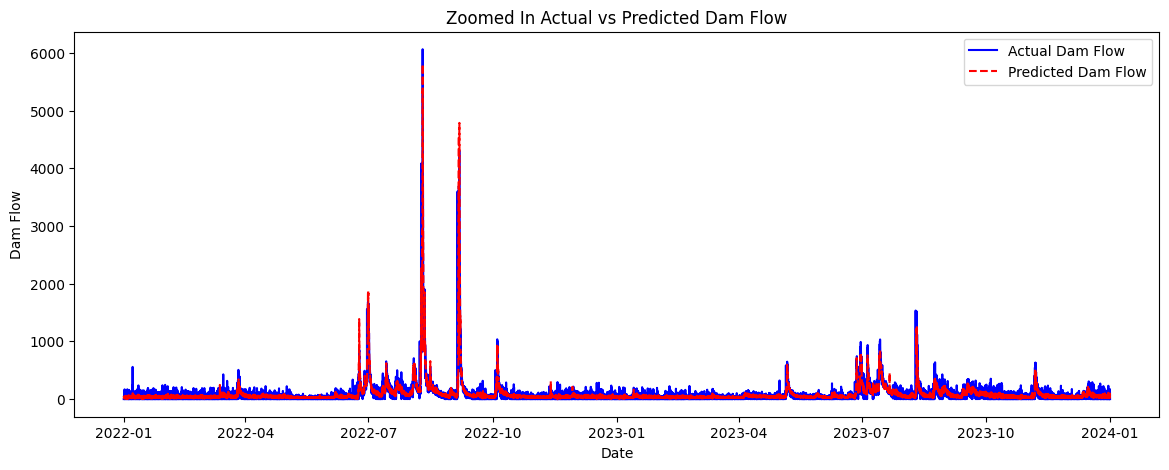

In [135]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*24*2
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

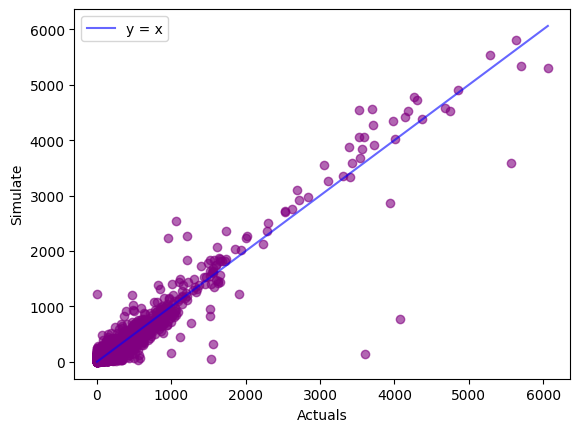

In [136]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [137]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 70.60


In [138]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.892637


In [139]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -8.918811


In [140]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.893835
